<a href="https://colab.research.google.com/github/NILEG/TensorFlow/blob/main/Time_Series_with_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%load_ext tensorboard

####Generating Data

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish

    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """

    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level

    return noise

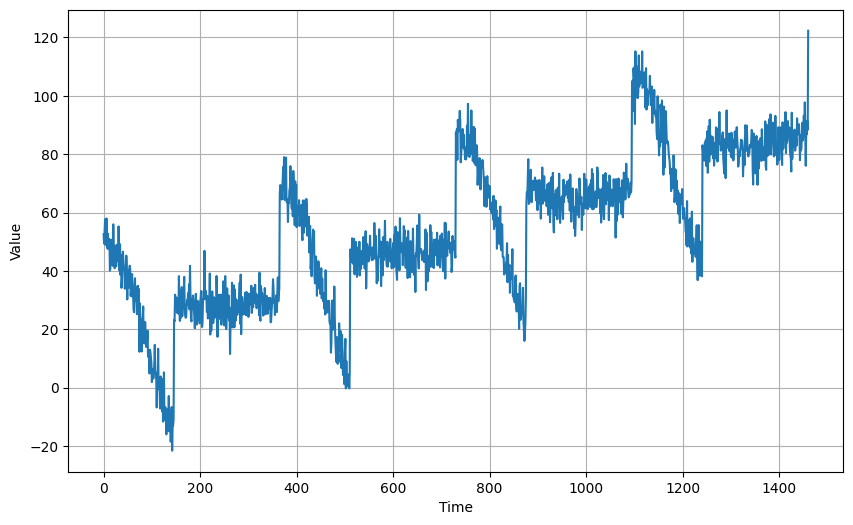

In [3]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

####Splitting Data

In [4]:
SPLIT_TIME=1000
train_series=series[:SPLIT_TIME]
test_series=series[SPLIT_TIME:]

train_time=time[:SPLIT_TIME]
test_time=time[SPLIT_TIME:]

####Window Function(Features & Labels)

In [5]:
window_size=20
buffer=1000
batch_size=32

In [6]:
def windowed_dataset(series, window_size, buffer, batch_size):
  dataset=tf.data.Dataset.from_tensor_slices(series)
  dataset=dataset.window(window_size+1, shift=1, drop_remainder=True)
  dataset=dataset.flat_map(lambda x:x.batch(window_size+1))
  dataset=dataset.map(lambda x: (x[:-1], x[-1]))
  dataset=dataset.shuffle(buffer)
  dataset=dataset.batch(batch_size).prefetch(1)
  return dataset

In [7]:
dataset=windowed_dataset(train_series, window_size, buffer, batch_size)

####Model Building

#####Initial Model

In [8]:
model=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(window_size, )),
    tf.keras.layers.Lambda(lambda x:tf.expand_dims(x, axis=-1)),
    tf.keras.layers.SimpleRNN(units=40, return_sequences=True),
    tf.keras.layers.SimpleRNN(units=40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x:x*100)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 20, 1)             0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 20, 40)            1680      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 40)                3240      
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 4961 (19.38 KB)
Trainable params: 4961 (19.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.SGD(momentum=0.9))

In [ ]:
lr_callback=tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
history=model.fit(dataset, epochs=100, callbacks=[lr_callback])

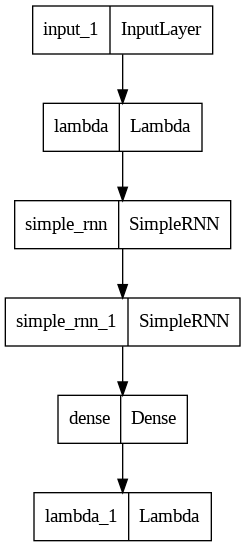

In [11]:
tf.keras.utils.plot_model(model)

#####Choosing Learning Rate

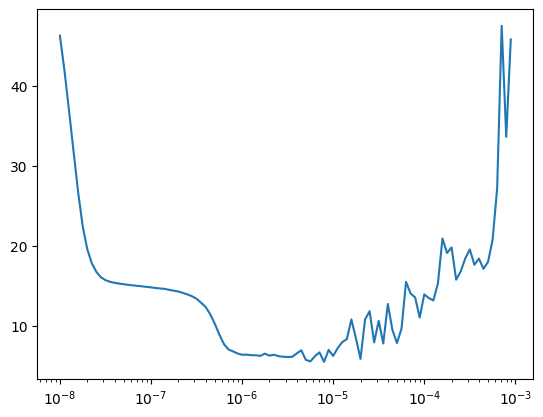

In [15]:
lr=history.history["lr"]
loss=history.history["loss"]
plt.semilogx(lr, loss)

#####Observation:
The optimum lr is 10^-5

In [ ]:
fined_model=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(window_size,)),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
    tf.keras.layers.SimpleRNN(units=40, return_sequences=True),
    tf.keras.layers.SimpleRNN(units=40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*100)
])
fined_model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.SGD(momentum=0.9, learning_rate=0.000001), metrics=["mae"])
history=fined_model.fit(dataset, epochs=100, verbose=1)

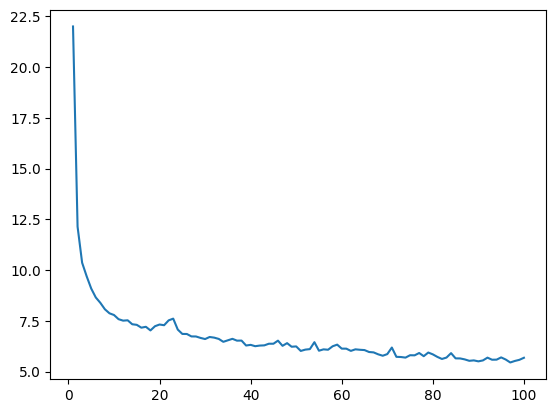

In [21]:
plt.plot(range(1,101), history.history["mae"])

In [27]:
def forecast(series, window_size, batch):
  dataset=tf.data.Dataset.from_tensor_slices(series)
  dataset=dataset.window(window_size, shift=1, drop_remainder=True)
  dataset=dataset.flat_map(lambda x: x.batch(window_size))
  dataset=dataset.batch(batch).prefetch(1)
  return dataset

In [ ]:
prediction=fined_model.predict(forecast(series[SPLIT_TIME-window_size: -1], window_size, batch_size))
prediction=prediction.squeeze()
prediction

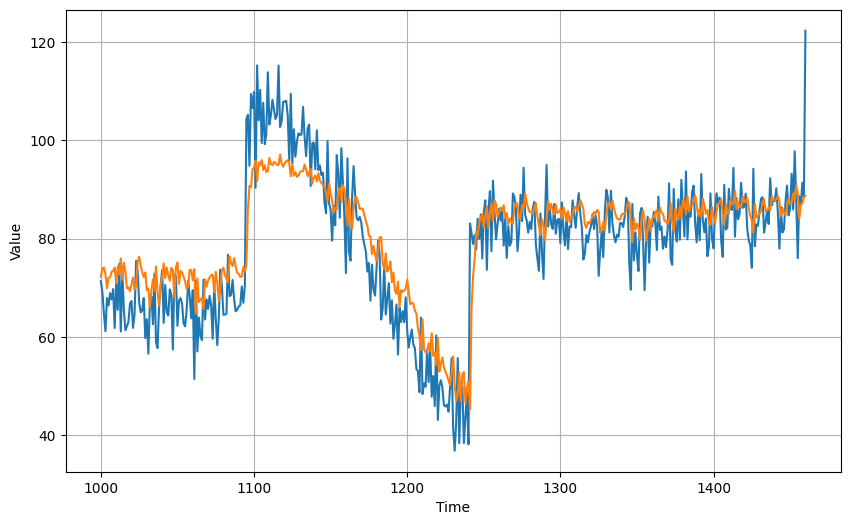

In [30]:
plot_series(test_time, (test_series, prediction))

#####Average MAE

In [32]:
mae=tf.keras.losses.mae(test_series, prediction)
mae.numpy()

6.1646924